In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
import sys
from os import listdir
from os.path import isfile, join, exists
import matplotlib.pyplot as plt
import scipy

from scipy.spatial.distance import pdist,squareform,cosine,euclidean,mahalanobis
from statsmodels.stats.multitest import multipletests
import scipy.io as sio
import scipy.stats as stats
from IPython.core.debugger import set_trace
from tqdm import tqdm
import time
import copy
from numpy.polynomial.polynomial import polyfit

import seaborn as sns

from PIL import Image

from sklearn.manifold import MDS
from sklearn.linear_model import LinearRegression

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
import torchvision.datasets as datasets 

import importlib

sys.path.append('/home/jacobpri/git/RotspaceIT/')

from RotspaceIT import rsatools as rsa
from RotspaceIT import nnutils as utils

importlib.reload(utils)
importlib.reload(rsa)


<module 'RotspaceIT.rsatools' from '/home/jacobpri/git/RotspaceIT/RotspaceIT/rsatools.py'>

In [2]:
# plan: 

#Split data in half, find best layer from dnFA/faceNet, in second half of data, get corrs, 
#repeat that over a bunch of splits, 
#then do paired t test on the difference. 
#Dn RDMs same each time but might be from different layers 
#since choice of layer depends on brain (this doesn’t take into 
#                                        account unique variance - maybe should do t test over data w shared var removed?)
#Another option: same thing but now you’re doing it as a function of more unique variance rather than rdm corrs [USE THIS!]


# (1) split data in half
# (2) run the pipeline up through variance partitioning where you learn unique var explained by faceNet/dnFA
# (3) store those respective values
# (4) repeat with another random split of the data

In [3]:
fmri_dataset = 'Cohen2017'
arch = 'alexnet' # 
imageset = 'mc8-lummatched' #
loc_imageset = 'imagefiles-fullset' # 
img_dim = 224 # 
FDR_p = 0.05 # 
rdv_dist = 'correlation' # 
batch_size = 40 #
save_as = '.npy'

save_layer_rdvs = True
overwrite = False
verbose = True

In [4]:
# modalities
modalities = ['neural','deepnet','imgstats','behavior'] # behavior too?

opts = dict()
opts['regions'] = ['FFA','PPA'] # 
if 'imagefiles' in loc_imageset:
    opts['loc_domain_idx'] = [1,3] # must correspond to the ordering of the brain regions imagefiles is 1,3. vpnl is 0,3
elif 'vpnl' in loc_imageset:
    opts['loc_domain_idx'] = [0,3]
opts['deepnet_regions'] = ['dnFA','dnPA'] # 
opts['expimg_validation_idx'] = [0,3] # faces, buildings indices in the exp dataset # 0,3 for mc8, 
opts['sel_check_method'] = 'z'
opts['selectivity_threshold'] = 2 # units of z scores above the mean of non-pref categs

opts['trainsets'] = ['object','face','scene','random']

if fmri_dataset == 'Cohen2017':
    opts['datatypes_avail'] = ['univar','rdv'] ## others to add for models: MDS. lesioning gets separate thing?
    opts['levels_avail'] = ['categ']
    opts['data_fn'] = 'RoiRsa_reordered.mat'
    opts['struct_name'] = 'R'
    opts['roi_fieldname'] = 'roiList'
    opts['univar_fieldname'] = 'roiCondMeans'
    opts['rdv_fieldname'] = 'roiRsaSubCube'
    opts['categ_strs_u'] = np.array(['faces','bodies','cats','cars','hammers','phones','chairs','buildings'])
    opts['categ_strs_m'] = opts['categ_strs_u']
    opts['plot_order'] = np.array([0,1,2,4,6,7,5,3])
    
elif fmri_dataset == 'Baker2018':
    opts['datatypes_avail'] = ['rdv']
    opts['levels_avail'] = ['categ']
    opts['data_fn'] = 'Baker.mat'
    opts['struct_name'] = 'Baker'
    opts['roi_fieldname'] = 'roiList'
    opts['univar_fieldname'] = []
    opts['rdv_fieldname'] = []
    opts['categ_strs_u'] = np.array(['faces','cats','bodies','cars','hammers','phones','chairs','buildings'])
    opts['categ_strs_m'] = ['birds', 'boats', 'body parts', 'butterflies', 'cars', 'churches', 'cityscapes', 'clothes', 'deserts""dishes', 'accessories', 
    'dolls', 'factories', 'farm animals', 'fire', 'flowers', 'food', 'forests', 'houses', 'bugs', 'adults', 'kids', 'kitchens', 'living rooms', 'masks', 
    'motorscycles', 'mountains', 'older adults', 'pets', 'airplanes', 'pools', 'roads', 'signs', 'lizards/snakes', 'spiders', 'sports', 'suburbs', 'tools', 
    'toys', 'trains', 'appliances', 'wild animals', 'gyms', 'bags', 'bathrooms', 'beaches', 'beds', 'bikes']
    opts['plot_order'] = np.arange(len(opts['categ_strs_m']))
    opts['n_reliable_categs_incl'] = 48
    
if loc_imageset == 'imagefiles-fullset':
    opts['loc_domain_list'] = ['Bodies','Faces','Objects','Scenes','Scrambled']
elif loc_imageset == 'vpnl-floc':
    opts['loc_domain_list'] = ['faces','bodies','objects','scenes','characters','scrambled']
    
if 'mc8' in imageset:
    opts['categ_idx_u'] = np.repeat(np.arange(8), 30)
    opts['categ_idx_m'] = np.repeat(np.arange(8), 30)
elif 'baker' in imageset:
    opts['categ_idx_u'] = np.repeat(np.arange(8), 30)
    opts['categ_idx_m'] = np.repeat(np.arange(48), 3)
    

In [5]:
home_dir = '/home/jacobpri/git/RotspaceIT/'
data_dir = '/user_data/jacobpri/Project/RotspaceIT/'

# target directory for saving activations
activation_savedir = join(data_dir,'data','d02_modeling','activations')

# target directory for saving layer-wise RDVs
rdv_savedir = join(data_dir,'data','d02_modeling','rdvs')

# folder of trained model weights
weight_dir = join(data_dir,'data','d02_modeling','weights')

# folder of fmri data
fmri_dir = join(data_dir, 'data','d03_processing', fmri_dataset)

# folder of image sets
imageset_dir = join(home_dir,'imagesets')

load_arch = arch + '-' + 'object'

dirs = os.listdir(imageset_dir)

found = False
for d in dirs:
    d_ = os.listdir(join(imageset_dir,d))
    if (imageset in d_):
        imageset_dir = join(imageset_dir, d, imageset)
        activation_savedir = join(activation_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        rdv_savedir = join(rdv_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        found = True
        break
    
if not exists(fmri_dir):
    raise ValueError('processed fmri data not found')

In [6]:
def fill_silent_imgs(X):

    # again, check to be sure all images evoke activation somewhere. if not, fill with tiny randoms to avoid errors
    bad_idx = np.argwhere(np.sum(X,axis=1)==0)
    if len(bad_idx) > 0:
        for ii in bad_idx:
            X[ii] = np.random.normal(0,0.000001,(1,X.shape[1]))
            
    return X


In [16]:
save_dir = join(data_dir,'data','d04_RSA','RSAModels')
os.makedirs(save_dir,exist_ok=True)

save_str = f"RSAModel_fMRI-{fmri_dataset}_arch-{arch}_locimg-{loc_imageset}_expimg-{imageset}_dim-{img_dim}_dm-{rdv_dist}_FDR-{FDR_p}_neural-{'-'.join(opts['regions'])}_deepnet-{'-'.join(opts['deepnet_regions'])}.npy"
save_fn = join(save_dir, save_str)

print(save_fn)

if exists(save_fn) and overwrite == False:
    print('RSAModel already exists. loading...')
    R = np.load(save_fn,allow_pickle=True).item()
    
    fmri_fn = join(fmri_dir,'fmri_roidata_submean.npy')
    fmri_data = np.load(fmri_fn,allow_pickle=True).item()
    
else:

    # dict for al RSA variables
    R = dict()
    for mod in modalities:
        R[mod] = dict()
        
    # helper #1, get brain RDMs
    # save relevant files
    fn = join(fmri_dir,'fmri_roidata_submean.npy')
    fmri_data = np.load(fn,allow_pickle=True).item()

    for mod in modalities:
        if mod == 'neural':
            for region in opts['regions']:
                R[mod][region] = dict()

                for datatype in opts['datatypes_avail']:
                    R[mod][region][datatype] = dict()

                    for level in opts['levels_avail']:
                        R[mod][region][datatype][level] = fmri_data[region][datatype][level]
                        
                        
    # helper #2, get model RDMs
    for trainset in opts['trainsets']:

        load_arch_ = arch + '-' + trainset

        # target directory for saving layer-wise pref dicts
        prefdict_savedir = join(data_dir,'data','d02_modeling','selectivity', load_arch_, 'localizer', loc_imageset, 'dim' + str(img_dim))

        ## load preference dict for a given locset/model/param combination
        load_str = 'layer_pref_dicts_FDR_p_' + str(FDR_p).replace('.','-') + save_as
        load_fn = join(prefdict_savedir,load_str)
        if not exists(load_fn):
            print(load_fn)
            raise ValueError('pref dict does not exist')

        else:
            # load pref dict
            pref_dict = np.load(load_fn, allow_pickle=True).item()
            layers = list(pref_dict.keys())

            # for each layer...
            for layer in tqdm(layers):

                # for each selectivity domain of interest...
                for dom in range(len(opts['loc_domain_idx'])):

                    # create label for this deepnet model/layer combo
                    idx = opts['loc_domain_idx'][dom]
                    dn_reg = opts['deepnet_regions'][dom]
                    model_layer = f'{trainset}_{dn_reg}_{layer}'

                    R['deepnet'][model_layer] = dict()
                    R['deepnet'][model_layer]['univar'] = dict()
                    R['deepnet'][model_layer]['rdv'] = dict()
                    R['deepnet'][model_layer]['mds'] = dict()

                    # get indices of selective neurons
                    selective_idx = pref_dict[layer]['domain_idx'][idx]
                    print(model_layer, len(selective_idx))
                    
                    R['deepnet'][model_layer]['selective_idx'] = selective_idx
                    R['deepnet'][model_layer]['n_selective'] = len(selective_idx)
                    
                    if imageset == 'bakerboth':
                        imageset_ = 'bakerset1'
                    else:
                        imageset_ = imageset

                    # load batched activations
                    act_loaddir = join(data_dir, 'data','d02_modeling', 'activations', 
                                       load_arch_, 'experimental', imageset_, 'dim' + str(img_dim))

                    if not exists(act_loaddir):
                        print(act_loaddir)
                        raise ValueError('act dir not found')

                    # load acts and subselect selective units
                    Y_u = utils.load_batched_activations(act_loaddir, layer, batch_size)
                    Y_m = copy.deepcopy(Y_u)
                                                                   
                    R['deepnet'][model_layer]['prop_selective'] = len(selective_idx) / Y_u.shape[1]
                    
                    # goal: have Y_sel and Y_sel_, two copies. 
                    # Y_sel_u is used for all univariate things, Y_sel_m is used for all rdms
                    # in baker, Y_sel_u gets overwritten by cohen acts, Y_sel_m is the mean of 2 baker sets
                    
                    Y_sel_u = copy.deepcopy(Y_u)[:,selective_idx]
                    Y_sel_m = copy.deepcopy(Y_m)[:,selective_idx]
                    
                    # average activations from second image set
                    if 'baker' in imageset:
                        
                        if 'both' in imageset:
                            imageset2 = 'bakerset2'
                            
                             # load batched activations
                            act_loaddir2 = join(data_dir, 'data','d02_modeling', 'activations', 
                                           load_arch_, 'experimental', imageset2, 'dim' + str(img_dim))

                            # load acts and subselect selective units
                            Y_set2 = utils.load_batched_activations(act_loaddir2, layer, batch_size)
                            Y_set2_sel = copy.deepcopy(Y_set2)[:,selective_idx]

                            # whole layer acts are mean of 2 image sets
                            Y_m = np.nanmean(np.stack([Y_m, Y_set2],axis=2),axis=2)

                            # selective subset acts are mean of 2 image sets
                            Y_sel_m = np.nanmean(np.stack([Y_sel_m, Y_set2_sel],axis=2),axis=2)
                        
                        act_loaddir3 = join(data_dir, 'data','d02_modeling', 'activations', 
                                       load_arch_, 'experimental', 'mc8-lummatched', 'dim' + str(img_dim))
                        
                        # replace univariate acts with cohen ones -> todo, remove this and just save+load validity info
                        Y_ = utils.load_batched_activations(act_loaddir3, layer, batch_size)
                        Y_u = copy.deepcopy(Y_)
                        Y_sel_u = copy.deepcopy(Y_u)[:,selective_idx]
                    
                    # again, check to be sure all images evoke activation somewhere. if not, fill with tiny randoms to avoid errors
                    Y_sel_u = fill_silent_imgs(Y_sel_u)
                    Y_sel_m = fill_silent_imgs(Y_sel_m)

                    # if there are at least 2 selective units, compute means and rdvs
                    if Y_sel_u.shape[1] > 1:
                        R['deepnet'][model_layer]['univar']['item'] = rsa.univar_mean(Y_sel_u)
                        R['deepnet'][model_layer]['univar']['categ'] = rsa.univar_mean(rsa.collapse_categs(Y_sel_u,opts['categ_idx_u']))
                        
                        #print(R['deepnet'][model_layer]['univar']['categ'])
                        
                        R['deepnet'][model_layer]['rdv']['item'] = rsa.rdv(Y_sel_m, rdv_dist)
                        R['deepnet'][model_layer]['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(Y_sel_m,opts['categ_idx_m']), rdv_dist)

                        # if there are no categories that have 0 activations for all imgs, perform MDS
                        if np.sum(R['deepnet'][model_layer]['univar']['categ'] == 0) == 0:
                            try:
                                embedding = MDS(n_components=2,dissimilarity='precomputed',random_state=365)
                                mds_coords = embedding.fit_transform(rsa.v2m(R['deepnet'][model_layer]['rdv']['item']))
                                R['deepnet'][model_layer]['mds']['item'] = mds_coords
                            except:
                                print('warning: subset MDS failed', model_layer)
                                R['deepnet'][model_layer]['mds']['item'] = np.nan
                        else:
                            print('skipping MDS for ', model_layer)
                            R['deepnet'][model_layer]['mds']['item'] = rsa.nan_matrix((Y_sel_m.shape[0],2))

                    # else, no selective subset, fill everything with nans    
                    else:
                        print(f'fewer than 2 selective units in {model_layer}')
                        R['deepnet'][model_layer]['univar']['item'] = rsa.nan_matrix((Y_sel_u.shape[0],))
                        R['deepnet'][model_layer]['univar']['categ'] = rsa.nan_matrix((len(opts['categ_strs_u']),))

                        R['deepnet'][model_layer]['rdv']['item'] = rsa.nan_matrix((len(rsa.rdv(np.random.normal(0,1,(Y_sel_m.shape[0],2)))),))
                        R['deepnet'][model_layer]['rdv']['categ'] = rsa.nan_matrix((len(rsa.rdv(np.random.normal(0,1,(len(opts['categ_strs_m']),2))))),)

                        R['deepnet'][model_layer]['mds']['item'] = rsa.nan_matrix((Y_sel_m.shape[0],2))


                    # once we're done with the selective subsets, compute means/rdvs/MDS at the whole layer level 
                    if dom == len(opts['loc_domain_idx']) - 1:
                        model_layer = f'{trainset}_layer_{layer}'

                        # again, check to be sure all images evoke activation somewhere. if not, fill with tiny randoms to avoid errors
                        Y_u = fill_silent_imgs(Y_u)
                        Y_m = fill_silent_imgs(Y_m)
                                
                        R['deepnet'][model_layer] = dict()
                        R['deepnet'][model_layer]['univar'] = dict()
                        R['deepnet'][model_layer]['univar']['item'] = rsa.univar_mean(Y_u)
                        R['deepnet'][model_layer]['univar']['categ'] = rsa.univar_mean(rsa.collapse_categs(Y_u,opts['categ_idx_u']))

                        R['deepnet'][model_layer]['rdv'] = dict()
                        R['deepnet'][model_layer]['mds'] = dict()

                        # load precomputed rdv if it exists
                        rdv_loaddir = join(data_dir, 'data','d02_modeling', 'rdvs', 
                                       load_arch_, 'experimental', imageset_, 'dim' + str(img_dim))

                        fn = join(rdv_loaddir,f'{layer}_rdv_dist_{rdv_dist}.npy')

                        if exists(fn):
                            rdv = np.load(fn)
                            R['deepnet'][model_layer]['rdv']['item'] = rdv

                        # if not, compute it here
                        else:
                            print('rdv not yet saved')
                            print('computing item-level rdv using all layer neurons...')
                            print('dim = ', Y_m.shape)
                            R['deepnet'][model_layer]['rdv']['item'] = rsa.rdv(Y_m, rdv_dist)

                        R['deepnet'][model_layer]['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(Y_m,opts['categ_idx_m']), rdv_dist)

                        # if there are no categories that have 0 activations for all imgs, perform MDS
                        if np.sum(R['deepnet'][model_layer]['univar']['categ'] == 0) == 0:
                            try:
                                embedding = MDS(n_components=2,dissimilarity='precomputed',random_state=365)
                                mds_coords = embedding.fit_transform(rsa.v2m(R['deepnet'][model_layer]['rdv']['item']))
                                R['deepnet'][model_layer]['mds']['item'] = mds_coords
                            except:
                                print('warning: layer MDS failed..', model_layer)
                                R['deepnet'][model_layer]['mds']['item'] = np.nan
                        else:
                            R['deepnet'][model_layer]['mds']['item'] = rsa.nan_matrix((Y_m.shape[0],2))


    # directory for loading low-level image stat data
    gist_savedir = join(data_dir,'data','d02_modeling','gist', 'experimental', imageset_)

    load_strs = ['GistPCFeatures.mat','GaborFeatures.mat']

    R['imgstats']['gistPC'] = dict()
    R['imgstats']['gistPC']['rdv'] = dict()
    R['imgstats']['gabor'] = dict()
    R['imgstats']['gabor']['rdv'] = dict()

    for load_str in load_strs:

        load_fn = join(gist_savedir,load_str)
        if not exists(load_fn):
            print(load_fn)
            raise ValueError('feature file does not exist')

        else:
            features = sio.loadmat(load_fn)[load_str.split('.')[0]]
            
            if 'bakerboth' in imageset:
                gist_savedir = join(data_dir,'data','d02_modeling','gist', 'experimental', 'bakerset2')
                load_fn = join(gist_savedir,load_str)
                if not exists(load_fn):
                    print(load_fn)
                    raise ValueError('feature file does not exist')

                else:
                    features_set2 = sio.loadmat(load_fn)[load_str.split('.')[0]]
                    
                features = np.nanmean(np.stack([features, features_set2],axis=2),axis=2)

            if 'gist' in load_str.lower():
                R['imgstats']['gistPC']['rdv']['item'] = rsa.rdv(features, rdv_dist)
                R['imgstats']['gistPC']['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(features, opts['categ_idx_m']), rdv_dist)
            elif 'gabor' in load_str.lower():
                R['imgstats']['gabor']['rdv']['item'] = rsa.rdv(features, rdv_dist)
                R['imgstats']['gabor']['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(features, opts['categ_idx_m']), rdv_dist)


    # TODO: add baker behavioral data
    # directory for loading behavioral data
    behav_loaddir = join(data_dir,'data','d01_rawdata',fmri_dataset)

    load_str = 'SearchRT_reordered.mat'

    load_fn = join(behav_loaddir,load_str)
    
    if not exists(load_fn):
        print(load_fn)
        print('behavioral data does not exist, skipping...')
        R['behavior']['search_rts'] = rsa.nan_matrix((len(rsa.rdv(np.random.normal(0,1,(len(opts['categ_strs_m']),2))))),)
    else:
        rts = sio.loadmat(load_fn)['SearchRT']
        R['behavior']['search_rts'] = rts

    R['layers'] = layers
    
    np.save(save_fn, R)



/user_data/jacobpri/Project/RotspaceIT/data/d04_RSA/RSAModels/RSAModel_fMRI-Cohen2017_arch-alexnet_locimg-imagefiles-fullset_expimg-mc8-lummatched_dim-224_dm-correlation_FDR-0.05_neural-FFA-PPA_deepnet-dnFA-dnPA.npy
RSAModel already exists. loading...


In [17]:
fmri_data.keys()

dict_keys(['roi_list', 'roi_univar_subcube', 'roi_rsa_subcube', 'FFA', 'OFA', 'FBA', 'EBA', 'LO', 'PPA', 'TOS', 'MT', 'VentralOTC', 'LateralOTC', 'OPC', 'EarlyV2', 'VentralOTCRemoved', 'LateralOTCRemoved', 'OPCRemoved', 'EarlyV2Removed'])

/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered


(-0.2, 1)

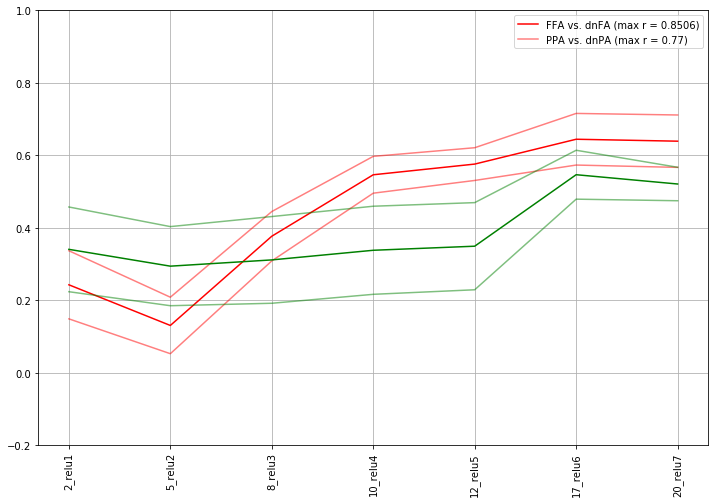

In [34]:
layers = R['deepnet'].keys()
plt.figure(figsize=(12,8))
#print(includes)

FFAdata = np.squeeze(fmri_data['roi_rsa_subcube'][np.argwhere(fmri_data['roi_list']=='FFA')])
PPAdata = np.squeeze(fmri_data['roi_rsa_subcube'][np.argwhere(fmri_data['roi_list']=='PPA')])

# plt.figure()
# plt.imshow(FFAdata,aspect='auto')
# plt.figure()
# plt.imshow(PPAdata,aspect='auto')
# plt.show()

maxes = []
for roi in ['FFA','PPA']:
    maxes_ = []
    subj_data = []
    for s in range(FFAdata.shape[0]):
        if roi is 'FFA':
            dnroi = 'dnFA'
        else:
            dnroi = 'dnPA'

        includes = [layer for layer in layers if dnroi in layer and 'object' in layer]
        corrs = []
        for lay in includes:
            if 'relu' in lay:
                corr = np.corrcoef(R['deepnet'][lay]['rdv']['categ'], FFAdata[s])
                corrs.append(corr[1,0])
        #if roi == 'FFA':
        #    plt.plot(corrs,'r')
        #else:
        #    plt.plot(corrs,'g')
        maxes_.append(np.nanmax(corrs))
        subj_data.append(corrs)
    subj_data = np.vstack(subj_data)
    
    if roi == 'FFA':
        c = 'r'
    elif roi == 'PPA':
        c = 'g'
    plt.plot(np.nanmean(subj_data,axis=0),c)
    plt.plot(np.nanmean(subj_data,axis=0) + (np.nanstd(subj_data,axis=0)/np.sqrt(5)),c,alpha=0.5)
    plt.plot(np.nanmean(subj_data,axis=0) - (np.nanstd(subj_data,axis=0)/np.sqrt(5)),c,alpha=0.5)
    maxes.append(np.nanmax(maxes_))
    
labels = []
for lay in includes:
    if 'relu' in lay:
        labels.append(lay[12:])
    
plt.legend([f'FFA vs. dnFA (max r = {round(maxes[0],4)})', f'PPA vs. dnPA (max r = {round(maxes[1],4)})'])
plt.xticks(np.arange(len(labels)), np.array(labels),rotation=90);
plt.grid('on')
plt.ylim([-0.2,1])

array([[1.        , 0.81185753],
       [0.81185753, 1.        ]])